# Read in train File, and initial data analysis


In [1]:
#First, import all necessary libraries for data cleaning
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

In [2]:
#second, load in training data first
train_df = pd.read_csv('merged_df_2016.csv',header=0,parse_dates = ['transactiondate','transaction_month','yearbuilt','assessmentyear'])
train_df.drop(['Unnamed: 0'],axis=1,inplace = True)
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 41 columns):
parcelid                             90275 non-null int64
logerror                             90275 non-null float64
transactiondate                      90275 non-null datetime64[ns]
transaction_month                    90275 non-null object
basementsqft                         90275 non-null float64
bathroomcnt                          90275 non-null float64
bedroomcnt                           90275 non-null float64
buildingqualitytypeid                90275 non-null float64
calculatedfinishedsquarefeet         89614 non-null float64
fips                                 90275 non-null float64
fireplacecnt                         90275 non-null float64
fullbathcnt                          90275 non-null float64
garagetotalsqft                      29937 non-null float64
hashottuborspa                       90275 non-null bool
heatingorsystemtypeid                90275 non-nul

,parcelid,logerror,transactiondate,transaction_month,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fips,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,taxdelinquencyflag,censustractandblock,garagetotalsqft_median,unitcnt_median,calculatedfinishedsquarefeet_mean,numberofstories_median,calculatedfinishedsquarefeet_reg
0,11016594,0.0276,2016-01-01,1,0.0,2.0,3.0,4.0,1684.0,6037.0,...,122754.0,360170.0,2015.0,N,6.037107e+13,433.0,1.0,1684.0,1.440739,1684.0
1,14366692,-0.1684,2016-01-01,1,0.0,3.5,4.0,4.0,2263.0,6059.0,...,346458.0,585529.0,2015.0,N,NaN,468.0,1.0,2263.0,1.440739,2263.0
2,12098116,-0.0040,2016-01-01,1,0.0,3.0,2.0,4.0,2217.0,6037.0,...,61994.0,119906.0,2015.0,N,6.037464e+13,433.0,1.0,2217.0,1.440739,2217.0
3,12643413,0.0218,2016-01-02,1,0.0,2.0,2.0,4.0,839.0,6037.0,...,171518.0,244880.0,2015.0,N,6.037296e+13,433.0,1.0,839.0,1.440739,839.0
4,14432541,-0.0050,2016-01-02,1,0.0,2.5,4.0,4.0,2283.0,6059.0,...,169574.0,434551.0,2015.0,N,6.059042e+13,598.0,1.0,2283.0,2.000000,2283.0


In [3]:
grouped_fips=train_df[['fips','calculatedfinishedsquarefeet_reg','logerror','taxvaluedollarcnt','structuretaxvaluedollarcnt']].groupby('fips').mean().reset_index()


# The log error is significantly higher for fips 6111 due to very few transactions. 

/Users/Macjuliahu1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


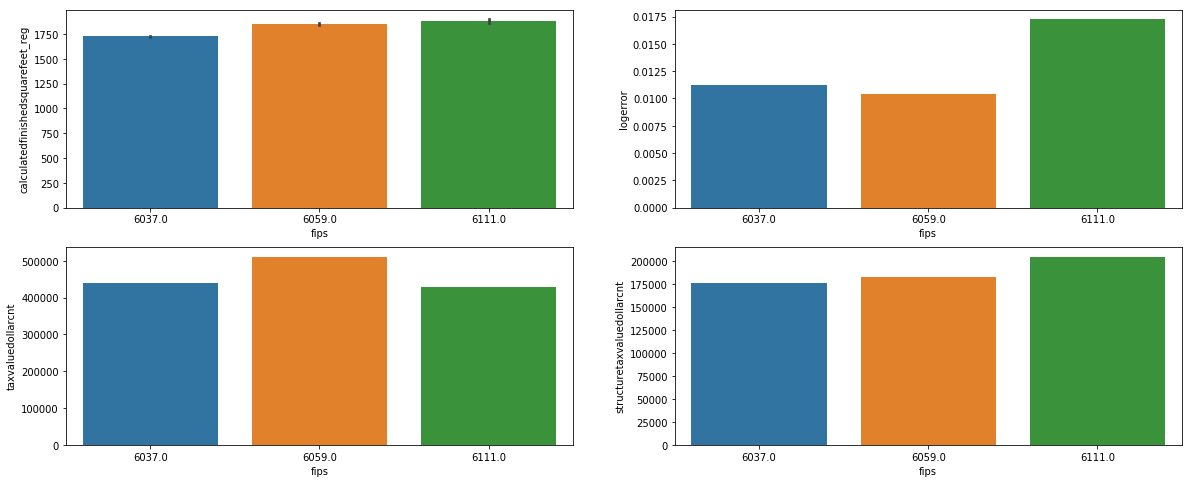

In [4]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(20,8)
sns.barplot(x='fips', y = 'calculatedfinishedsquarefeet_reg', data= train_df, ax=axes[0,0])
sns.barplot(x = 'fips', y = 'logerror',data= grouped_fips, ax=axes[0,1])
sns.barplot(x='fips', y = 'taxvaluedollarcnt', data= grouped_fips, ax=axes[1,0])
sns.barplot(x='fips', y = 'structuretaxvaluedollarcnt', data= grouped_fips, ax=axes[1,1])

structuretaxvaluedollarcnt is linearly correlated with calculatedfinishedsquarefeet_reg. This makes sense. Logerror is the biggest for fips 6111. It seems fips 6059 has expensive land values. 

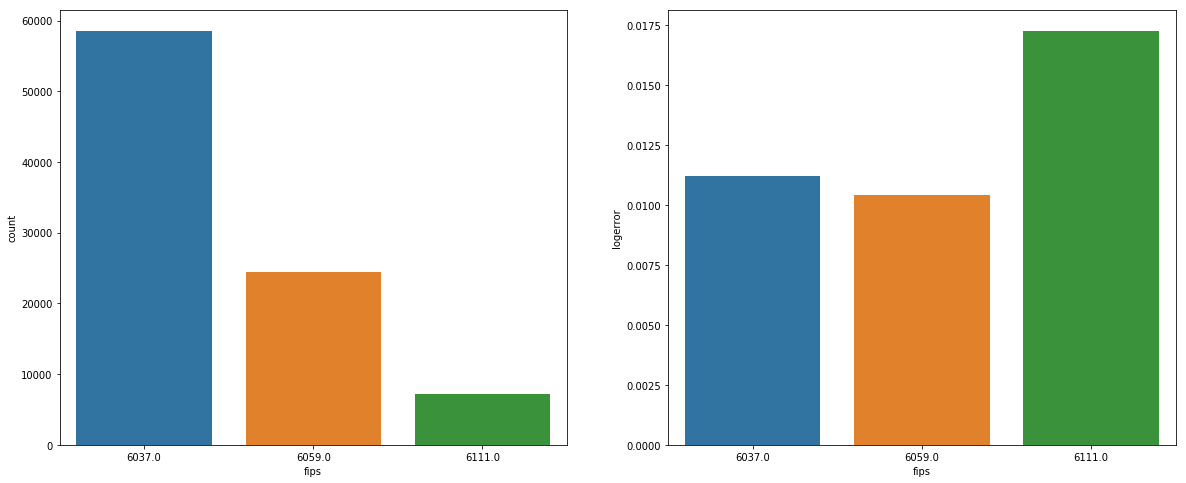

In [5]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sns.countplot(x='fips', data= train_df, ax=ax1)
sns.barplot(x = 'fips', y = 'logerror',data= grouped_fips, ax=ax2)

Clearly, fips 6111 has fewest training data, and largest logerrors.

# Multicolinearity analysis

[Text(0, 0.5, 'Features'),
 Text(0.5, 0, 'VIF Scores'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

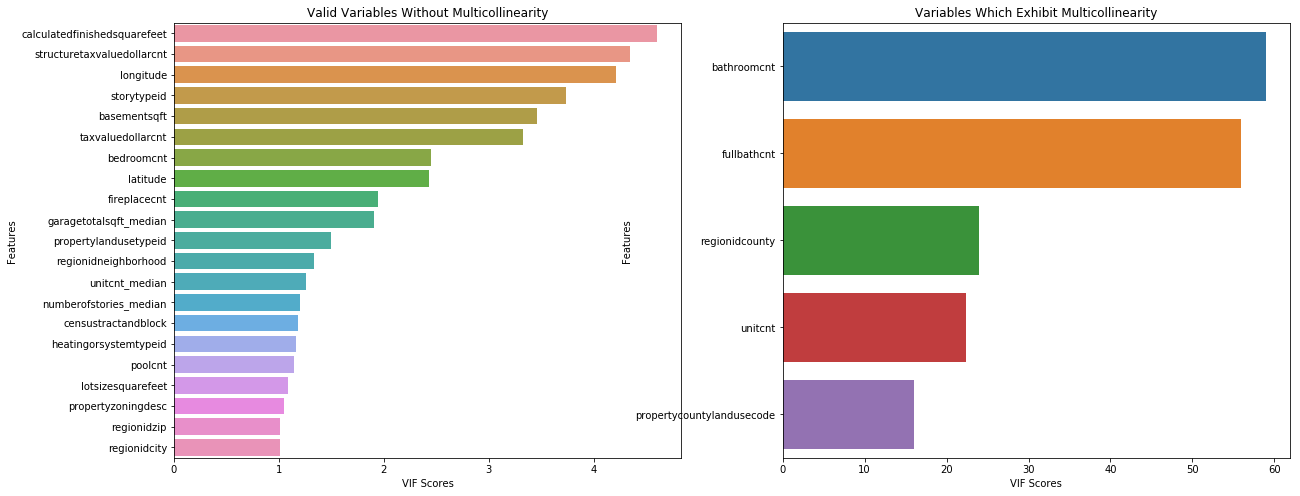

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

numericalCol = []
for f in train_df.columns:
    #print (f)
    if train_df[f].dtype!='object' and train_df[f].dtype!='bool' and f not in ["parcelid", "transactiondate", "transaction_month", "logerror", "buildingqualitytypeid", "calculatedfinishedsquarefeet_mean", "calculatedfinishedsquarefeet_reg"]:
        numericalCol.append(f)

mergedFilterd = train_df[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h")
sns.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

# More training data, then less log error for transaction_month

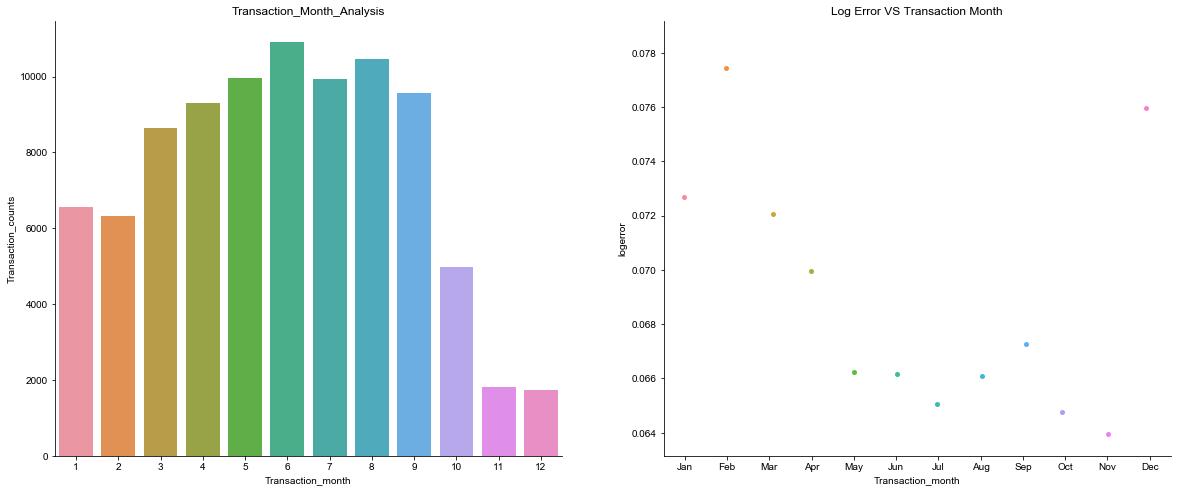

In [7]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month
month_analysis = train_df['transaction_month'].value_counts().sort_index()
mean = abs(train_df['logerror']).groupby(train_df['transaction_month']).mean()

fig,(ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(20,8)
sns.barplot(month_analysis.index,month_analysis.values, ax=ax1)
sns.stripplot(mean.index,mean.values,ax=ax2)
ax1.set_xlabel('Transaction_month')
ax1.set_ylabel('Transaction_counts')
ax1.set_title('Transaction_Month_Analysis')
label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#ax1.set_xticklabels(label)
#Set style to whitegrid
sns.set_style('whitegrid')
# Remove unwanted borders
sns.despine()



ax2.set_xlabel('Transaction_month')
ax2.set_ylabel('logerror')
ax2.set_title('Log Error VS Transaction Month')
label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax2.set_xticklabels(label)
# Set style to whitegrid
sns.set_style('whitegrid')
# Remove unwanted borders
sns.despine()

plt.show()


# No Of Stories Over The Years
It is quite interesting to notice people started building more of 2 or 3 storey buildings After 1950

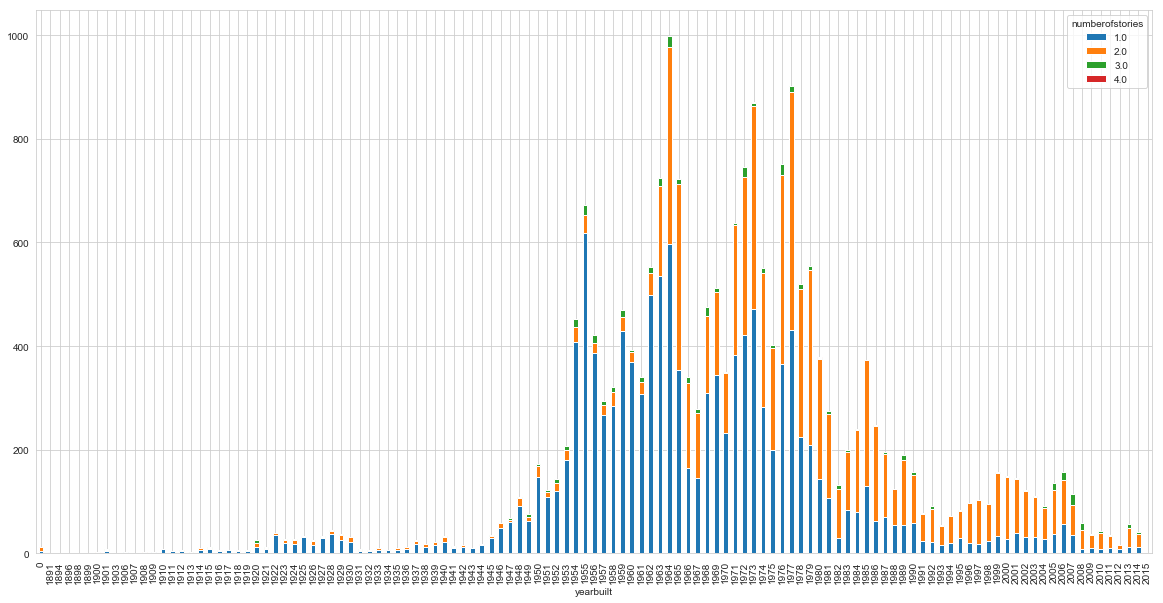

In [8]:
fig,ax1= plt.subplots()
fig.set_size_inches(20,10)
train_df["yearbuilt"] = train_df["yearbuilt"].map(lambda x:str(x).split(".")[0])
yearMerged = train_df.groupby(['yearbuilt', 'numberofstories'])["parcelid"].count().unstack('numberofstories')
yearMerged.plot(kind='bar', stacked=True,ax=ax1)

buildingqualitytypeid, use hue plot, buildingqualitytypeid 8 is outlier

In [9]:
grouped_quality=train_df[['fips','buildingqualitytypeid','logerror']].groupby(['fips','buildingqualitytypeid']).mean().reset_index()


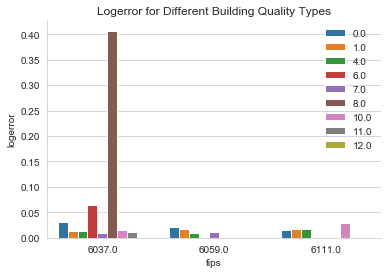

In [10]:
fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'buildingqualitytypeid', data=grouped_quality)
plt.title('Logerror for Different Building Quality Types')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

hashottuborspa have very little effect on log error

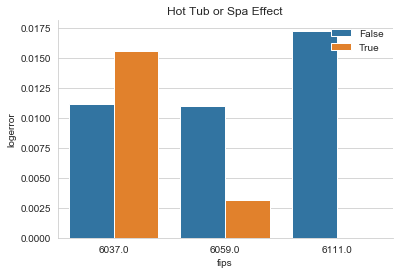

In [11]:
grouped_bathspa=train_df[['fips','hashottuborspa','logerror']].groupby(['fips','hashottuborspa']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'hashottuborspa', data=grouped_bathspa)
plt.title('Hot Tub or Spa Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

heatingorsystemtypeid again very little difference, but heatingstyleid 0 is outlier

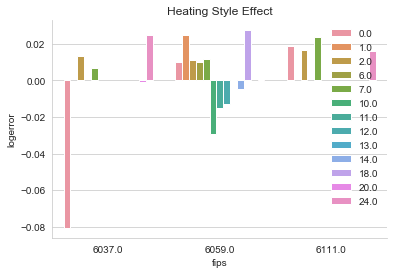

In [12]:
grouped_heating=train_df[['fips','heatingorsystemtypeid','logerror']].groupby(['fips','heatingorsystemtypeid']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'heatingorsystemtypeid', data=grouped_heating)
plt.title('Heating Style Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

propertylandusetypeid propertylandusetype 47 is outlier

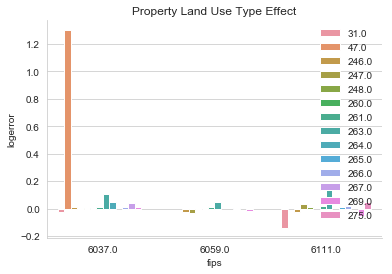

In [13]:
grouped_landuse=train_df[['fips','propertylandusetypeid','logerror']].groupby(['fips','propertylandusetypeid']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'propertylandusetypeid', data=grouped_landuse)
plt.title('Property Land Use Type Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

taxdelinquencyflag, tax delinquency makes a big difference on logerror

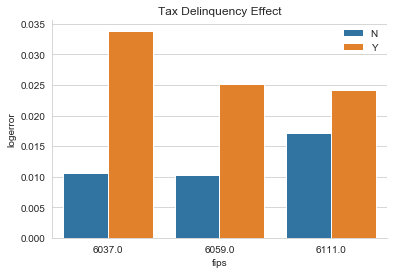

In [14]:
grouped_taxdelin=train_df[['fips','taxdelinquencyflag','logerror']].groupby(['fips','taxdelinquencyflag']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'taxdelinquencyflag', data=grouped_taxdelin)
plt.title('Tax Delinquency Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

yearbuilt with fips Vs logerror
yearbuilt with buildingquality Vs logerror

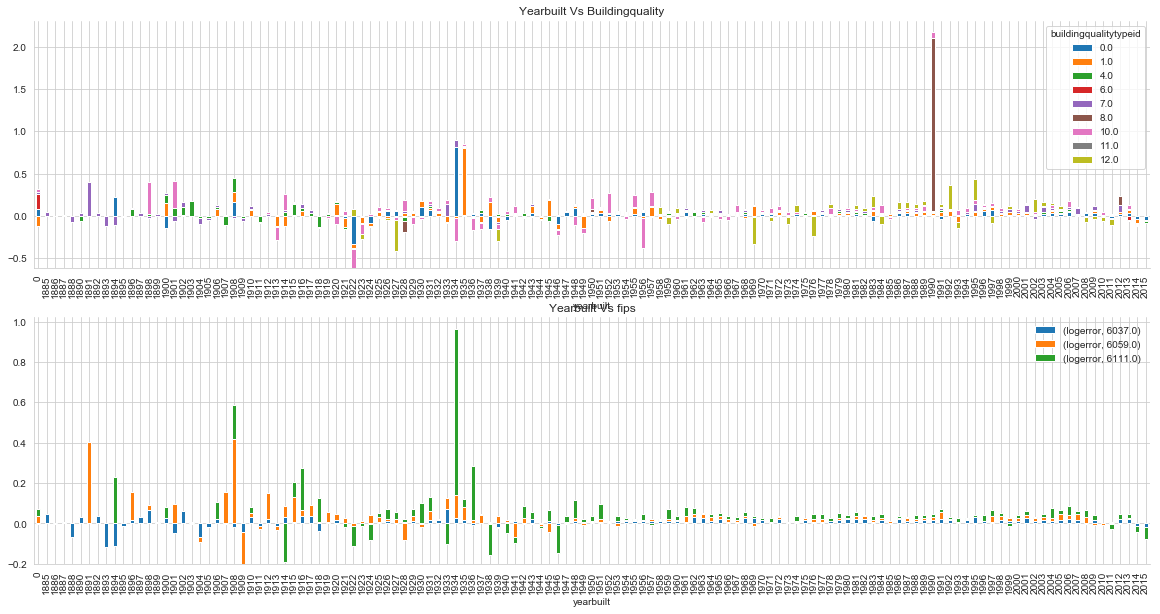

In [15]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,10)
train_df["yearbuilt"] = train_df["yearbuilt"].map(lambda x:str(x).split(".")[0])
yearqualityMerged = train_df.groupby(['yearbuilt', 'buildingqualitytypeid'])["logerror"].mean().unstack('buildingqualitytypeid')
yearqualityMerged.plot(kind='bar', stacked=True,ax=ax1)
ax1.set_title('Yearbuilt Vs Buildingquality')

grouped_yearbuilt=train_df[['yearbuilt','fips','logerror']].groupby(['yearbuilt','fips']).mean().unstack('fips')

grouped_yearbuilt.plot(kind='bar', stacked=True,ax=ax2)
ax2.set_title('Yearbuilt Vs fips')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

basement Vs logerror

In [16]:
train_df['basementsqft_bin'] = pd.cut(train_df['basementsqft'], bins=4, labels=["0", "100-500", "500-1000","1000-1500"])
train_df['basementsqft_bin'].value_counts()


0            90243
100-500         18
1000-1500        9
500-1000         5
Name: basementsqft_bin, dtype: int64

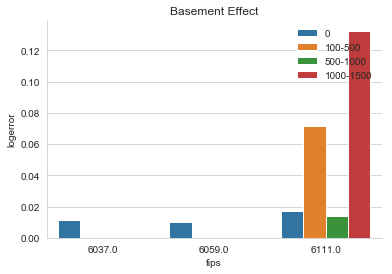

In [17]:
grouped_basement=train_df[['fips','basementsqft_bin','logerror']].groupby(['fips','basementsqft_bin']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'basementsqft_bin', data=grouped_basement)
plt.title('Basement Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

room number, for fips 6111, the room number equals to 13 make biggest mistake. This may due to very few samples to test.

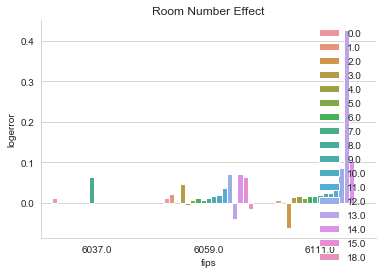

In [18]:
grouped_roomno=train_df[['fips','roomcnt','logerror']].groupby(['fips','roomcnt']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'roomcnt', data=grouped_roomno)
plt.title('Room Number Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

garagesqft Vs logerror

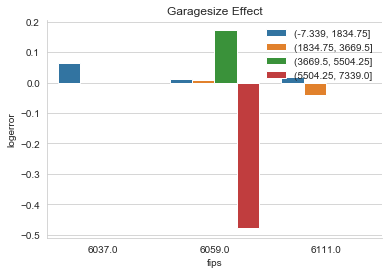

In [19]:

#train_df['garagetotalsqft'].value_counts()
train_df['garagesqft_bin'] = pd.cut(train_df['garagetotalsqft'], bins=4)
train_df['garagesqft_bin'].value_counts()

grouped_garage=train_df[['fips','garagesqft_bin','logerror']].groupby(['fips','garagesqft_bin']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'garagesqft_bin', data=grouped_garage)
plt.title('Garagesize Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

bathnumber&fullbathcnt Vs logerror 

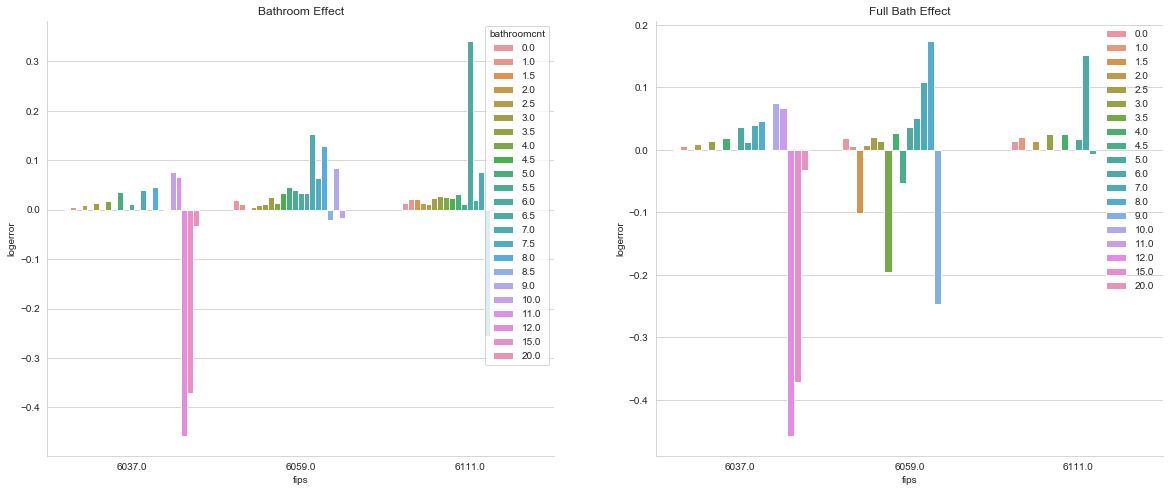

In [20]:
grouped_bathroom=train_df[['fips','bathroomcnt','logerror']].groupby(['fips','bathroomcnt']).mean().reset_index()
grouped_fullbath=train_df[['fips','fullbathcnt','logerror']].groupby(['fips','fullbathcnt']).mean().reset_index()
fig,(ax1,ax2)=plt.subplots(ncols = 2)
fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'bathroomcnt', data=grouped_bathroom,ax=ax1)
sns.barplot( x = 'fips',y= 'logerror', hue= 'fullbathcnt', data=grouped_fullbath,ax=ax2)
ax1.set_title('Bathroom Effect')
ax2.set_title('Full Bath Effect')
plt.legend(loc='upper right', frameon=False)

sns.set_style('whitegrid')
sns.despine()
plt.show()

fireplacecnt Vs logerror, Again fireplacecnt occures with large error, this is because very few samples. 

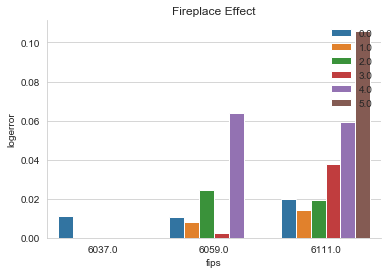

In [21]:
grouped_fireplace=train_df[['fips','fireplacecnt','logerror']].groupby(['fips','fireplacecnt']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'fireplacecnt', data=grouped_fireplace)
plt.title('Fireplace Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

poolcnt Vs logerror, pool count does not make a big difference in logerror. 

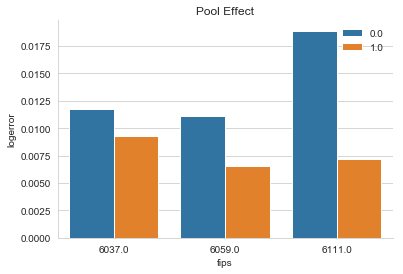

In [22]:
grouped_poolcnt=train_df[['fips','poolcnt','logerror']].groupby(['fips','poolcnt']).mean().reset_index()

fig.set_size_inches(20,8)

sns.barplot( x = 'fips',y= 'logerror', hue= 'poolcnt', data=grouped_poolcnt)
plt.title('Pool Effect')
plt.legend(loc='upper right', frameon=False)
sns.set_style('whitegrid')
sns.despine()
plt.show()

regionidcity Vs logerror, amount of available data make a big difference! bottom 5 city has at least 3 times higher error

No handles with labels found to put in legend.


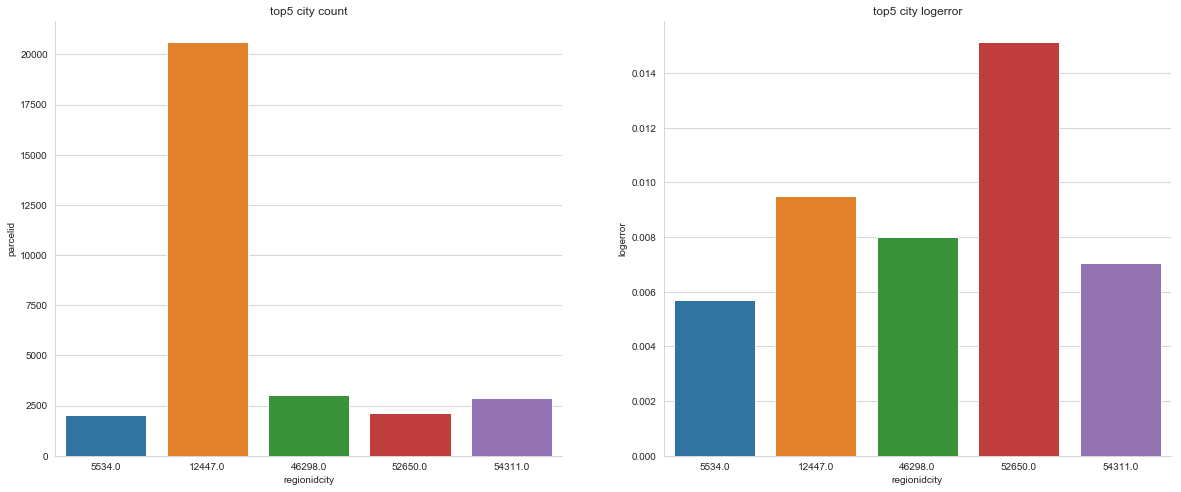

In [23]:
grouplog_df=train_df.groupby(['fips','regionidcity']).agg({'parcelid':'count','logerror':'mean'})
top5_df=grouplog_df.reset_index().sort_values(by = 'parcelid',ascending=False).head(5)

fig,(ax1,ax2)=plt.subplots(ncols = 2)
fig.set_size_inches(20,8)

sns.barplot( x = 'regionidcity',y= 'parcelid',  data=top5_df,ax=ax1)
sns.barplot( x = 'regionidcity',y= 'logerror',  data=top5_df,ax=ax2)
ax1.set_title('top5 city count')
ax2.set_title('top5 city logerror')
plt.legend(loc='upper right', frameon=False)

sns.set_style('whitegrid')
sns.despine()
plt.show()

No handles with labels found to put in legend.


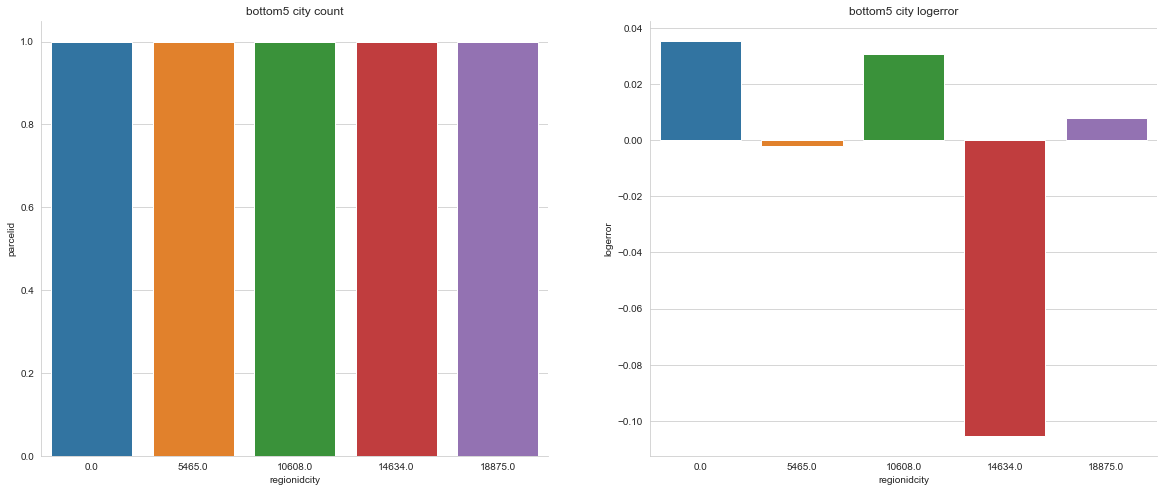

In [24]:
grouplog_df=train_df.groupby(['fips','regionidcity']).agg({'parcelid':'count','logerror':'mean'})
bottom5_df=grouplog_df.reset_index().sort_values(by = 'parcelid',ascending=False).tail(5)

fig,(ax1,ax2)=plt.subplots(ncols = 2)
fig.set_size_inches(20,8)

sns.barplot( x = 'regionidcity',y= 'parcelid',  data=bottom5_df,ax=ax1)
sns.barplot( x = 'regionidcity',y= 'logerror',  data=bottom5_df,ax=ax2)
ax1.set_title('bottom5 city count')
ax2.set_title('bottom5 city logerror')
plt.legend(loc='upper right', frameon=False)

sns.set_style('whitegrid')
sns.despine()
plt.show()

regionidneighborhood Vs logerror

No handles with labels found to put in legend.


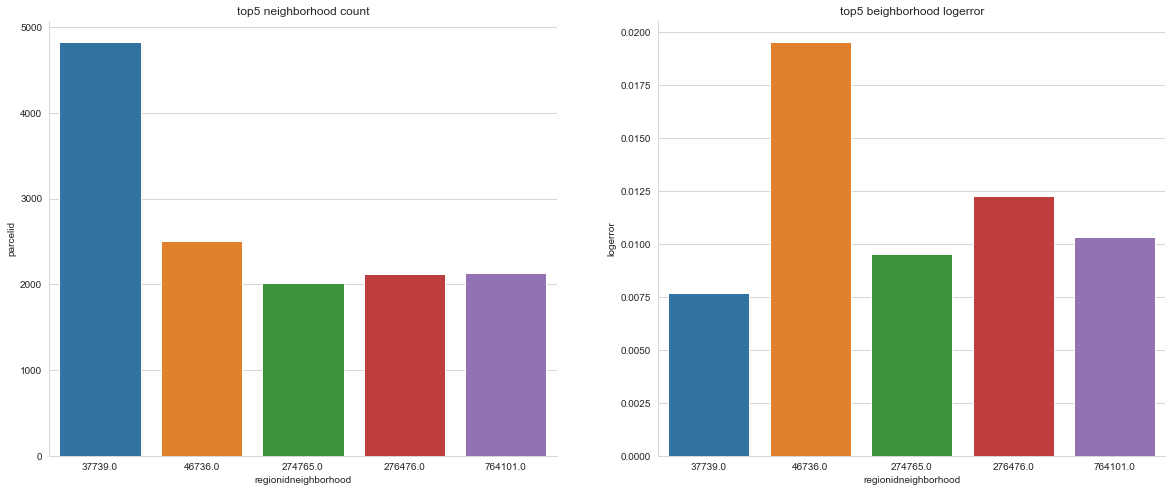

In [25]:
groupnei_df=train_df.groupby(['fips','regionidneighborhood']).agg({'parcelid':'count','logerror':'mean'})
top5_df=groupnei_df.reset_index().sort_values(by = 'parcelid',ascending=False).head(5)

fig,(ax1,ax2)=plt.subplots(ncols = 2)
fig.set_size_inches(20,8)

sns.barplot( x = 'regionidneighborhood',y= 'parcelid',  data=top5_df,ax=ax1)
sns.barplot( x = 'regionidneighborhood',y= 'logerror',  data=top5_df,ax=ax2)
ax1.set_title('top5 neighborhood count')
ax2.set_title('top5 beighborhood logerror')
plt.legend(loc='upper right', frameon=False)

sns.set_style('whitegrid')
sns.despine()
plt.show()

No handles with labels found to put in legend.


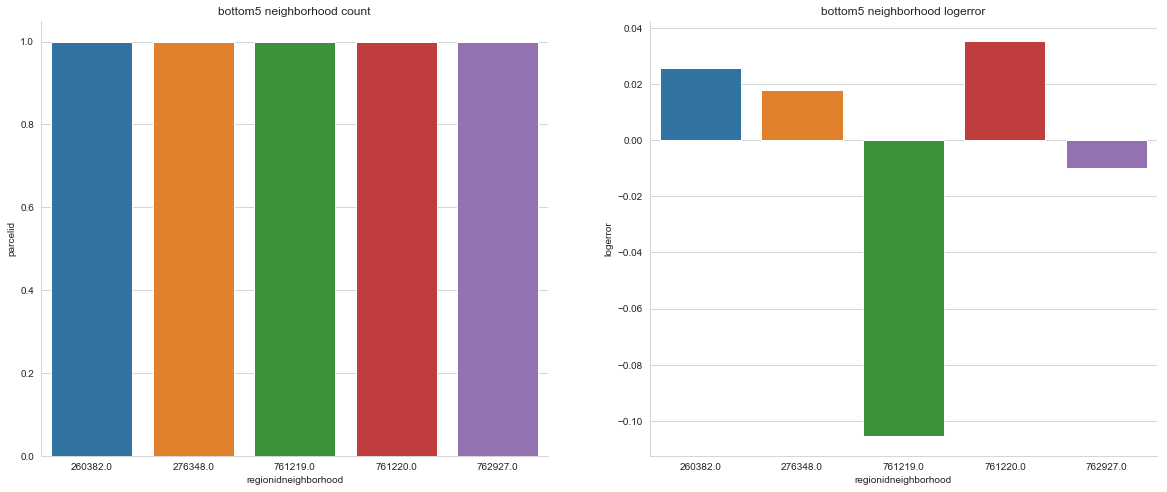

In [26]:
groupnei_df=train_df.groupby(['fips','regionidneighborhood']).agg({'parcelid':'count','logerror':'mean'})
bottom5_df=groupnei_df.reset_index().sort_values(by = 'parcelid',ascending=False).tail(5)

fig,(ax1,ax2)=plt.subplots(ncols = 2)
fig.set_size_inches(20,8)

sns.barplot( x = 'regionidneighborhood',y= 'parcelid',  data=bottom5_df,ax=ax1)
sns.barplot( x = 'regionidneighborhood',y= 'logerror',  data=bottom5_df,ax=ax2)
ax1.set_title('bottom5 neighborhood count')
ax2.set_title('bottom5 neighborhood logerror')
plt.legend(loc='upper right', frameon=False)

sns.set_style('whitegrid')
sns.despine()
plt.show()

# Outliers make a big impact on prediction accuracy

There are many outliers in different features, and these outliers degragate the machine learning accuracy a lot. This may be because lack of data for training for such extreme conditions, or lack of accurate information for such properties.

1. When 'roomcnt'>12, 'fullbathcnt' or 'bathroomcnt'>12, 'fireplacecnt' > 5,'garagetotalsqft'>3000, the logerrors go up a lot. When we check the count number for such propertyes, you will find they account for less than 

2. When 'yearbuilt' values are earlier than 1951, the logerrors are bigger.

3. When 'propertylandusetypeid' = 47, the logerrors are a lot bigger than others

4. When 'buidingquality' = 8, the logerrors are a lot bigger

# Amount of available training data also make a big difference on prediction accracy

For training dataset, with fewer records, the logerrors are bigger:
1. For all transaction months, the logerrors correlate with transaction records, fewer records, then bigger logerrors.

2. For all fips, the fips with fewest transaction records, fip=6111 has the biggest logerrors. 

3. 'basementsqft', since most basementsqft are 0, so the logerrors for this features are very large due to lack of training data.

4. bottom5 city log errors are 3 times higher than top5 city, and very similar trend appear in regionidneighborhood

# When there is unpredicatable event, the logerrors are tend to be bigger. 

3. Tax delinquencies flag make a big difference on prediction accuracy, when there is a sign of tax delinquencies, that means there is a urgent need for property sales, the sale prices were more unpredictable in this case, so the logerrors are a lot bigger. 

# Missing data impute based on traditional technique may cause problem

'heatingorsystemtypeid' is filled in by using 'yearbuilt', but there may be problem associated with such impute method, so the logerrors are bigger. 

'buildingquality'=8, which occurs almost all at year 1951, have large logerrors. I needs to check if these are generated from missing value imputes.  

'propertylandusetypeid'=47 also occures with large errors. 